[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!



Cosine Similarity Results:
--------------------------------------------------
Travel <-> Education: 0.0453
Sports <-> Education: 0.0453
Health <-> Education: 0.0413
Sports <-> Health: 0.0000
Sports <-> Travel: 0.0000
Health <-> Travel: 0.0000

Similarity Matrix:
--------------------------------------------------
Categories: ['Sports', 'Health', 'Travel', 'Education']

Matrix:
Sports         1.0000   0.0000   0.0000   0.0453 
Health         0.0000   1.0000   0.0000   0.0413 
Travel         0.0000   0.0000   1.0000   0.0453 
Education      0.0453   0.0413   0.0453   1.0000 


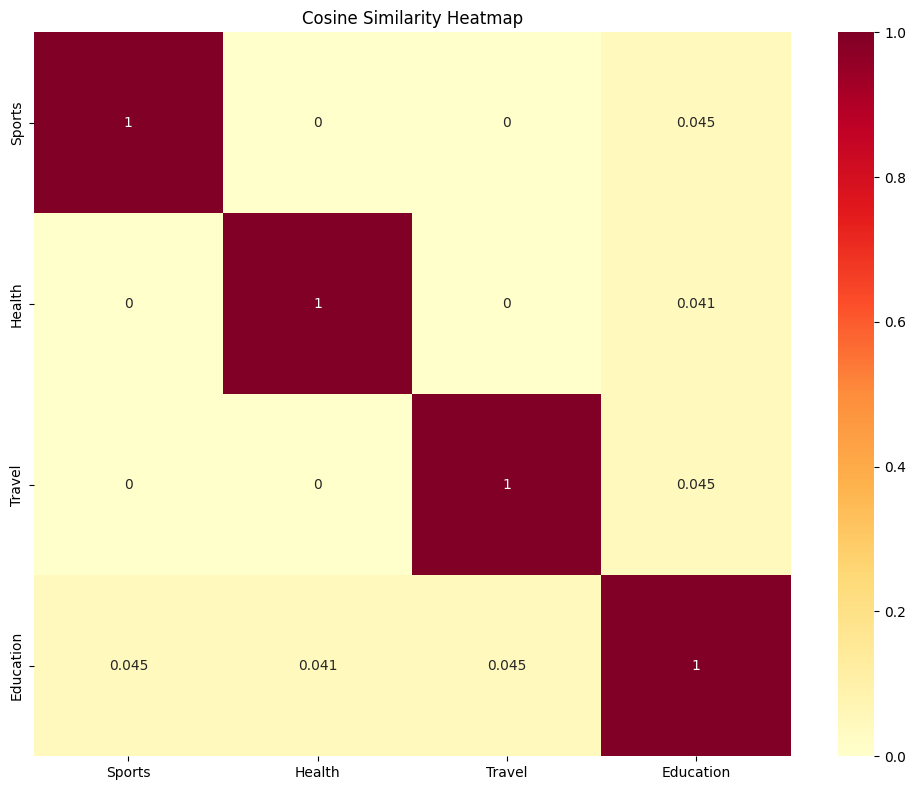

In [ ]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import string
# Download required NLTK data
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab') # Download the required punkt_tab resource.
from nltk.corpus import stopwords
import re

# Download required NLTK data
nltk.download('stopwords')
nltk.download('punkt')

class TextSimilarityAnalyzer:
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.vectorizer = TfidfVectorizer()

    def preprocess_text(self, text):
        """
        Preprocess the text by converting to lowercase, removing punctuation,
        special characters, and stop words
        """
        # Convert to lowercase
        text = text.lower()

        # Remove punctuation and special characters
        text = re.sub(r'[^\w\s]', '', text)

        # Tokenize and remove stop words
        tokens = nltk.word_tokenize(text)
        tokens = [word for word in tokens if word not in self.stop_words]

        return ' '.join(tokens)

    def extract_category_texts(self, document_content):
        """
        Extract texts by category from the document content
        """
        categories = {}
        current_category = None

        for line in document_content.split('\n'):
            line = line.strip()
            if not line:
                continue

            # Check if line is a category header
            if line[0].isdigit() and '.' in line:
                current_category = line.split('.')[1].strip()
                categories[current_category] = []
            # Add text to current category
            elif line.startswith('-') and current_category:
                text = line.replace('-', '').strip().strip('"')
                categories[current_category].append(text)

        return categories

    def calculate_similarities(self, categories):
        """
        Calculate cosine similarities between all category texts
        """
        # Prepare all texts
        category_combined_texts = {}
        for category, texts in categories.items():
            preprocessed_texts = [self.preprocess_text(text) for text in texts]
            category_combined_texts[category] = ' '.join(preprocessed_texts)

        # Convert to list for vectorization
        categories_list = list(category_combined_texts.keys())
        texts_list = [category_combined_texts[cat] for cat in categories_list]

        # Calculate TF-IDF vectors
        tfidf_matrix = self.vectorizer.fit_transform(texts_list)

        # Calculate cosine similarity
        similarity_matrix = cosine_similarity(tfidf_matrix)

        return categories_list, similarity_matrix

    def analyze_document(self, document_content):
        """
        Analyze the document and return similarity results
        """
        # Extract categories and their texts
        categories = self.extract_category_texts(document_content)

        # Calculate similarities
        categories_list, similarity_matrix = self.calculate_similarities(categories)

        # Format results
        results = []
        for i in range(len(categories_list)):
            for j in range(i + 1, len(categories_list)):
                results.append({
                    'category1': categories_list[i],
                    'category2': categories_list[j],
                    'similarity': similarity_matrix[i][j]
                })

        # Sort results by similarity score
        results.sort(key=lambda x: x['similarity'], reverse=True)

        return results, categories_list, similarity_matrix

def read_file(filename):
    """
    Read content from a text file
    """
    try:
        with open(filename, 'r', encoding='utf-8') as file:
            return file.read()
    except FileNotFoundError:
        print(f"Error: File '{filename}' not found.")
        return None
    except Exception as e:
        print(f"Error reading file: {str(e)}")
        return None

# Initialize analyzer
analyzer = TextSimilarityAnalyzer()

# Read the file
filename = "./sample_data_cosine.txt"  # Replace with your file path
document_content = read_file(filename)

if document_content:
    # Analyze the document
    results, categories_list, similarity_matrix = analyzer.analyze_document(document_content)

    # Print detailed results
    print("\nCosine Similarity Results:")
    print("-" * 50)
    for result in results:
        print(f"{result['category1']} <-> {result['category2']}: {result['similarity']:.4f}")

    # Print similarity matrix
    print("\nSimilarity Matrix:")
    print("-" * 50)
    print("Categories:", categories_list)
    print("\nMatrix:")
    for i, category in enumerate(categories_list):
        print(f"{category:12}", end=" ")
        for j in range(len(categories_list)):
            print(f"{similarity_matrix[i][j]:8.4f}", end=" ")
        print()
else:
    print("Could not proceed with analysis due to file reading error.")

# Optional: Add visualization
try:
    import matplotlib.pyplot as plt
    import seaborn as sns

    plt.figure(figsize=(10, 8))
    sns.heatmap(similarity_matrix,
                annot=True,
                cmap='YlOrRd',
                xticklabels=categories_list,
                yticklabels=categories_list)
    plt.title('Cosine Similarity Heatmap')
    plt.tight_layout()
    plt.show()
except ImportError:
    print("Matplotlib and/or seaborn not installed. Skipping visualization.")